# CS109A Final Project - Milestone 2
### Ilona Demler, Daniela Garcia, Kayla Manning, Saul Soto

This notebook contains the code used to produce our Milestone 2 Report.

## Import Libraries



In [12]:
# import standard libraries
import os
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import itertools
import math
import missingno as msno

# import model tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# import models objects
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# import viz libraries
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Loading the Data



In [ ]:
# get slice names (replace this with your own file path)
path_stem = "/Users/saul/CS109A/2021-CS109A/project/cs109a-final-project/Data/data/"
file_names = os.listdir(path_stem)
assert len(file_names) == 1000

# create empty data frame to store concatenated slices
playlist_data_raw = pd.DataFrame()

# combine each slice into one data frame 
for file in file_names:
    data_temp = pd.read_csv(path_stem + file)
    playlist_data_raw = playlist_data_raw.append(data_temp, ignore_index = True)    

In [104]:
# sample data 
playlist_data_sample = playlist_data_raw.sample(10000, random_state = 109, ignore_index = True)
playlist_data_sample.head()

,Unnamed: 0,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,798,Rap,False,342798,1503705600,201,143,1,"[{'pos': 0, 'artist_name': 'Wiz Khalifa', 'tra...",32,45908012,93,NaN
1,936,Workout,False,174936,1505952000,62,61,1,"[{'pos': 0, 'artist_name': 'PSY', 'track_uri':...",18,13274359,54,NaN
2,331,apr,False,53331,1497398400,48,43,1,"[{'pos': 0, 'artist_name': 'TOKiMONSTA', 'trac...",10,12333516,42,NaN
3,820,Yacht Rock,False,174820,1442102400,101,90,1,"[{'pos': 0, 'artist_name': 'Christopher Cross'...",2,25529025,77,NaN
4,575,Good Vibes,False,916575,1509062400,214,196,1,"[{'pos': 0, 'artist_name': 'Kaleo', 'track_uri...",123,46241434,152,NaN


In [1]:
# # save sampled dataset so that above process doesn't need to be rerun each time

# data_sample_file = "/Users/ilonademler/Documents/Harvard/Junior_fall/cs_109/final_project/cs109a-final-project/Data/data_sample.csv"
# playlist_data_sample.to_csv(data_sample_file)

'/Users/kaylamanning/Google Drive/Classes/2021-CS109A/content/cs109a-final-project'

In [62]:
data_sample_file = '/Users/kaylamanning/Google Drive/Classes/2021-CS109A/content/cs109a-final-project/Data/data_sample.csv'
data_sam = pd.read_csv(data_sample_file)
data_sam.head()
playlist_data_sample = data_sam[[c for c in data_sam.columns if 'Unnamed' not in c]]

## Cleaning the Data



In [63]:
# clean data

# initialize popular names, artists, songs
popular_names = ["country", "chill", "rap", "workout", "oldies", "christmas", "rock", "party", "throwback", 
                 "jams", "worship", "summer", "feels", "new", "disney", "lit", "throwbacks", "music", "sleep", "vibes"]

popular_artists = ["Drake", "Kanye West", "Kendrick Lamar", "Rihanna", "The Weeknd", "Eminem", "Ed Sheeran", "Future", 
                   "Justin Bieber", "J. Cole", "Beyoncé", "The Chainsmokers", "Chris Brown", "Calvin Harris", 
                   "Twenty One Pilots", "Lil Uzi Vert", "Post Malone", "Big Sean", "Maroon 5", "JAY Z"]

popular_tracks = ["HUMBLE. by Kendrick Lamar", "One Dance by Drake", "Broccoli (feat. Lil Yachty) by DRAM", 
                  "Closer by The Chainsmokers", "Congratulations by Post Malone", "Caroline by Aminé", 
                  "iSpy (feat. Lil Yachty) by KYLE", "Bad and Boujee (feat. Lil Uzi Vert) by Migos", "Location by Khalid",
                  "XO TOUR Llif3 by Lil Uzi Vert", "Bounce Back by Big Sean", "Ignition - Remix by R. Kelly", 
                  "No Role Modelz by J. Cole", "Mask Off by Future", "No Problem (feat. Lil Wayne & 2 Chainz) by Chance The Rapper",
                  "I'm the One by DJ Khaled", "Jumpman by Drake", "goosebumps by Travis Scott", "Fake Love by Drake",
                  "Despacito - Remix by Luis Fonsi"]

# extract predictor variables that don't need cleaning
playlist_data = playlist_data_sample[["num_tracks", "num_albums", "num_followers", "duration_ms", "num_artists"]].copy()

# initialize binary variables
playlist_data[["collaborative"]] = np.where(playlist_data_sample[["collaborative"]] == True, 1, 0)
playlist_data[["has_description"]] = np.where(playlist_data_sample[["description"]].isna(), 0, 1)

# create popular_name variable
popular_name = []
for playlist_name in playlist_data_sample["name"]:
    ## cast NaN values as strings
    if not isinstance(playlist_name, str):
        playlist_name = str(playlist_name)
    popular_name.append(np.where(any([name in playlist_name.lower() for name in popular_names]), 1, 0))
playlist_data[["popular_name"]] = pd.DataFrame(popular_name)

# extract track information
total_popular_tracks = []
total_popular_artists = []
playlist_tracks = playlist_data_sample["tracks"]

# iterate through each playlist
for track_data in playlist_tracks:
    # convert string to code
    track_data = eval(track_data)
    
    # initialize empty data frames to store data for each song in playlist
    pop_tracks = []
    pop_artists = []
    
    # iterate through each song in playlist
    for track_dict in track_data:
        track_name = track_dict["track_name"]
        artist_name = track_dict["artist_name"]
        
        # check if track name is popular
        if track_name + " by " + artist_name in popular_tracks:
            pop_tracks.append(1)
        else:
            pop_tracks.append(0)
        
        # check if artist name is popular
        if artist_name in popular_artists:
            pop_artists.append(1)
        else:
            pop_artists.append(0)
        
    
    # compute sum of popular songs and artists for that playlist
    total_popular_tracks.append(sum(pop_tracks))
    total_popular_artists.append(sum(pop_artists))

# add sums as new columns in data frame  
playlist_data[["total_popular_tracks"]] = pd.DataFrame(total_popular_tracks)
playlist_data[["total_popular_artists"]] = pd.DataFrame(total_popular_artists)


In [64]:
# display cleaned data
display(playlist_data.head())
display(playlist_data.describe())

,num_tracks,num_albums,num_followers,duration_ms,num_artists,collaborative,has_description,popular_name,total_popular_tracks,total_popular_artists
0,201,143,1,45908012,93,0,0,1,6,41
1,62,61,1,13274359,54,0,0,1,0,8
2,48,43,1,12333516,42,0,0,0,1,3
3,101,90,1,25529025,77,0,0,1,0,0
4,214,196,1,46241434,152,0,0,1,2,18


,num_tracks,num_albums,num_followers,duration_ms,num_artists,collaborative,has_description,popular_name,total_popular_tracks,total_popular_artists
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,66.245100,49.557600,3.371400,1.554039e+07,38.067800,0.022400,0.021100,0.261200,0.731500,5.787000
std,54.065833,40.310934,123.814745,1.294735e+07,30.478217,0.147988,0.143725,0.439311,1.908448,11.081061
min,5.000000,2.000000,1.000000,8.668210e+05,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,20.000000,1.000000,5.924127e+06,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,37.000000,1.000000,1.135958e+07,29.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,92.000000,68.000000,1.000000,2.145698e+07,52.000000,0.000000,0.000000,1.000000,0.000000,7.000000
max,250.000000,228.000000,10911.000000,1.036802e+08,208.000000,1.000000,1.000000,1.000000,19.000000,191.000000


## Generating Train and Test Sets



In [65]:
# split data into training and test data
X_data = playlist_data[["popular_name", "has_description", "num_artists", "num_albums", "num_tracks", 
                        "duration_ms", "collaborative", "total_popular_tracks", "total_popular_artists"]].copy()
y_data = playlist_data["num_followers"].copy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size = 0.8, random_state = 109)

## Explore Outcome Variable



Determine whether the response variable should be continuous or categorical:

In [ ]:
# plot histograms of outcome variable
fig, ax = plt.subplots(3, 1, figsize = (10,15))
fig.tight_layout(pad = 5)

ax[0].hist(y_train, edgecolor = 'black', bins=100)
ax[0].set_yscale("log")
ax[0].set_title("Distribution of playlist followers in entire dataset")
ax[0].set_xlabel("number of followers")
ax[0].set_ylabel("frequency")

ax[1].hist(y_train[y_train<5000], edgecolor = 'black', bins=100)
ax[1].set_yscale("log")
ax[1].set_title("Distribution of playlist followers between 0 and 5000")
ax[1].set_xlabel("number of followers")
ax[1].set_ylabel("frequency")

ax[2].hist(y_train[y_train<100], edgecolor = 'black', bins=100)
ax[2].set_yscale("log")
ax[2].set_title("Distribution of playlist followers between 0 and 100")
ax[2].set_xlabel("number of followers")
ax[2].set_ylabel("frequency");


**Interpretation**

Based on these histograms, it looks like the data largely falls into either under 20 followers, 20 - 5000 followers, or 40000+ followers.

To simplify our outcome variable, we will translate `num_followers` into a binary categorical variable with a **threshold of 20**. Playlists with 20+ followers will be considered "popular".

## EDA



### Collinearity

One way to check for collinearity is to plot a correlation matrix on a seaborn heatmap. The correlation matrix will show how strong a relationship is between two predictors, with correlation values close to 1 and -1 indicating a strong correlation. Predictors that are strongly correlated create a multicollinearity problem in regression, as regression usually assumes that the predictors are indepent of each other.

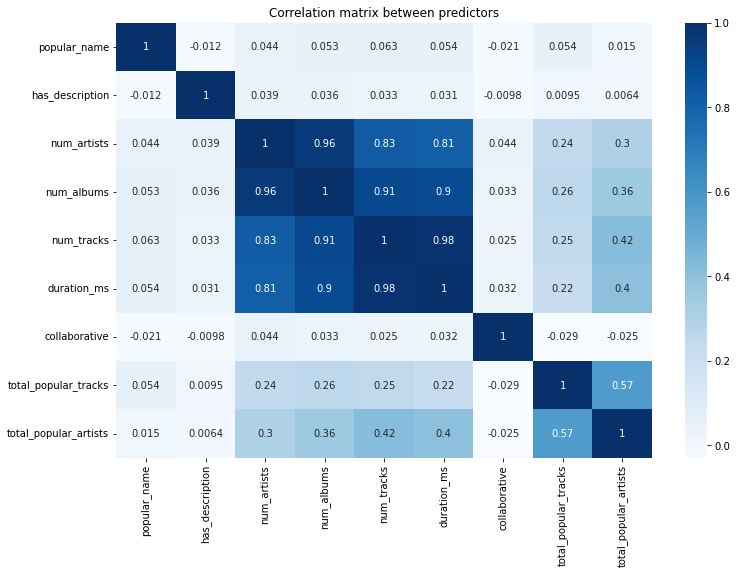

In [8]:
plt.figure(figsize=(12,8))
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='Blues').set_title('Correlation matrix between predictors');

From the correlation matrix, we can denote 6 strong relationships between variables:
* **num_tracks** and **duration_ms** (0.98)  
* **num_albums** and **num_artists** (0.96)
* **num_albums** and **num_tracks** (0.91)
* **duration_ms** and **num_albums** (0.9)
* **num_tracks** and **num_artists** (0.83)
* **duration_ms** and **num_artists** (0.81)


Another way to check collinearity between predictors is to do variance inflation factor (VIF), which checks for the variance in the regression coefficients. VIF performs a regression on one predictor against all the others, which allows it to find predictors with high variance due to collinearity. The higher the VIF value, the more likely the predictor is highly correlated with another and will affect our regression results.

In [9]:
# Source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame(X_train.columns, columns=['predictor'])
vif['variance'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

vif

,predictor,variance
0,popular_name,1.240949
1,has_description,1.019387
2,num_artists,35.840981
3,num_albums,64.106567
4,num_tracks,89.677351
5,duration_ms,80.618515
6,collaborative,1.025537
7,total_popular_tracks,1.766154
8,total_popular_artists,2.205189


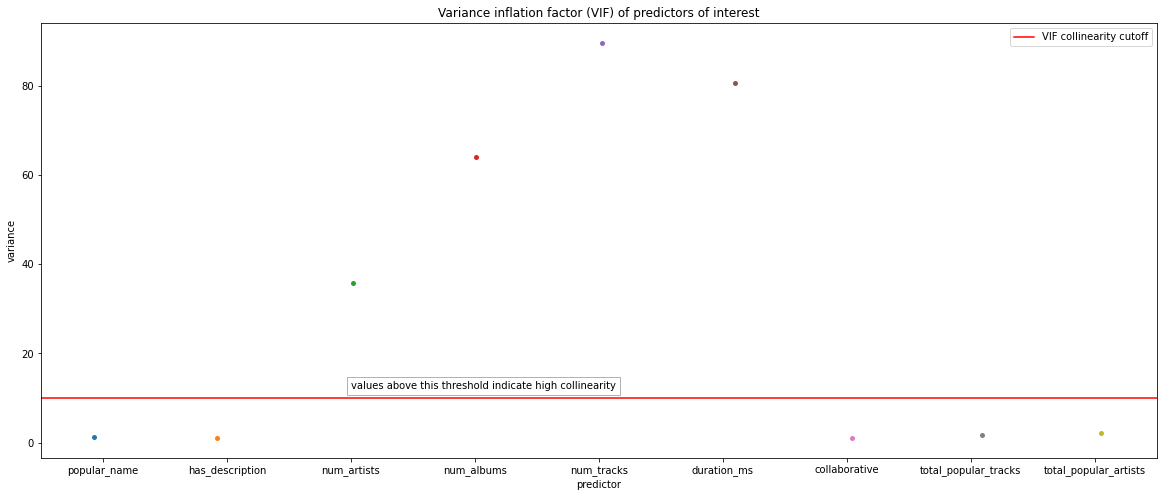

In [10]:
# Plotting the distribution of variances 
plt.figure(figsize=(20,8))
vif_dist = sns.stripplot(data=vif, x='predictor', y='variance')
vif_dist.axhline(y=10, color='r', label='VIF collinearity cutoff')
vif_dist.set_title('Variance inflation factor (VIF) of predictors of interest')
vif_dist.text(x=2, y=12, s='values above this threshold indicate high collinearity', bbox=dict(facecolor='white', alpha=0.3))
plt.legend()


As you can tell from the table and the scatter plot, there are four predictors that have an inflated variance when regressed on other variables. These are the same four predictors that the correlation matrix identified as having high correlatations with other variables, and the predictors with the highest correlation between other variables in ascending order is:
* **num_artists**
* **num_albums**
* **duration_ms**
* **num_tracks**

A lot of the correlation between the predictors make sense, as the more tracks you have the longer your playlist will be. Furthermore, since the number of albums and number of artists are not highly correlated with one another, we should expect to see that there are multiple albums coming from the same artist (or vice versa) in some of the playlists. When we go on to perform our regression, we will have to consider the relationship between these four predictors as they can skew our results to the extreme.

### Response variable vs. predictors

In [16]:
# will visualize based on the below 100 just so we have enough observations in each category... 
# the above plots were made with the entire y_data column rather than the train set
y_train_cat = np.where(y_train < 20, 'unpopular', 'popular')

# making sure I have a reasonable count of each category
from collections import Counter
Counter(y_train_cat.tolist())

Counter({'unpopular': 7983, 'popular': 17})

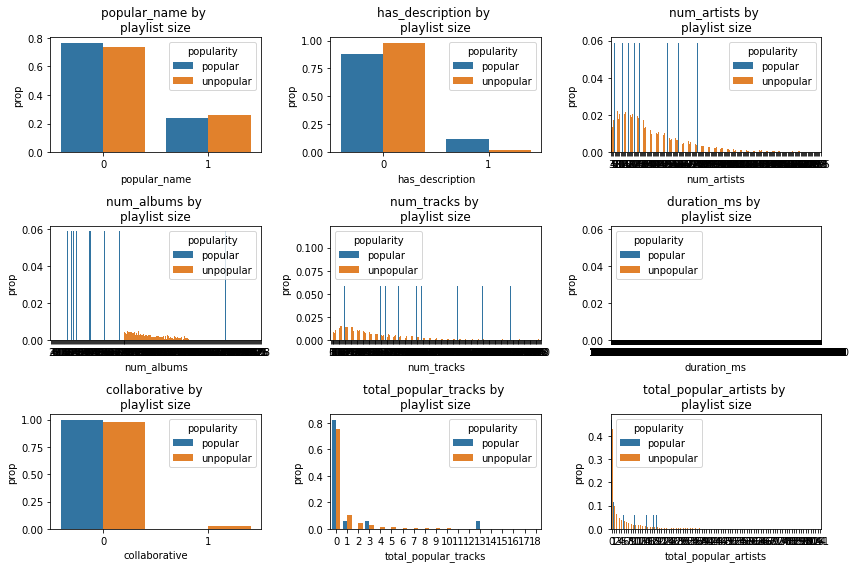

In [54]:
# will have to plot continuous and discrete variables differently
continuous_prefixes = ['num_', 'total_', 'duration_']
continuous_vars = [c for c in X_train.columns if c in continuous_prefixes]

# creating whole training set so I can group by y_train_cat and do normalized plots with 
# percentages rather than counts
train = X_train.copy()
train['popularity'] = y_train_cat

# looping through and doing subplots
fig, ax = plt.subplots(3,3, figsize=(12,8))
for i, c in enumerate(X_train.columns):
    
    # using this so I can assign the plots to the proper axes
    col = i%3
    row = int((i - i%3)/3)
    
    # doing a histplot for continuous, filling for the category
    if c in continuous_vars:
        sns.histplot(x=c, stat='proportion', data=train, hue=popularity, ax=ax[row,col])
        
        # setting x-ticks so they are legible
        max_x = max(train[c])
        if max_x > 10e6:
            ax[row,col].set_xticks(range(0, max_x, 10e5))
        elif max_x > 150:
            ax[row,col].set_xticks(range(0, max_x, 50))
        else:
            ax[row,col].set_xticks(range(0, max_x, 2))
    
    # want a countplot with frequences for discrete variables, filling for category
    else:
        # getting normalized values for the counts
        this_train = train.groupby('popularity')[c].value_counts(normalize=True)
        this_train = this_train.rename('prop').reset_index()
        sns.barplot(x=c, y='prop', hue='popularity', data=this_train, ax=ax[row,col])
    
    # formatting the plots with appropriate labels
    ax[row,col].set_xlabel(c)
    ax[row,col].set_title(f'{c} by \nplaylist size')
    
fig.tight_layout();

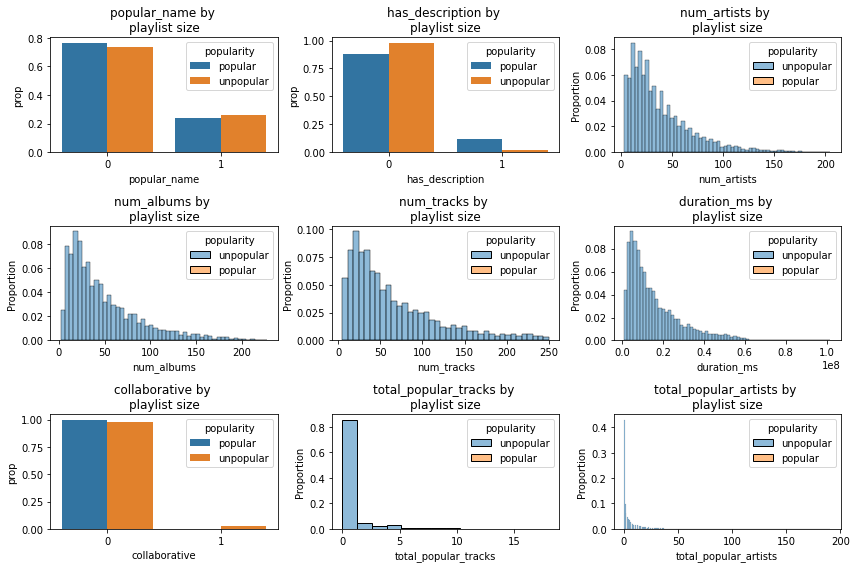

In [80]:
# will have to plot continuous and discrete variables differently
cat_vars = ["popular_name", "has_description", "collaborative"]
col_names = list(X_train.columns)

# creating whole training set so I can group by y_train_cat and do normalized plots with 
# percentages rather than counts
train = X_train.copy()
train['popularity'] = y_train_cat

# looping through and doing subplots
fig, ax = plt.subplots(3,3, figsize=(12,8))
for i in range(len(col_names)):
    
    # using this so I can assign the plots to the proper axes
    col = i%3
    row = int((i - i%3)/3)
    
    if col_names[i] in cat_vars:
        # want a boxplot for discrete variables, stratified by outcome
        this_train = train.groupby('popularity')[col_names[i]].value_counts(normalize=True)
        this_train = this_train.rename('prop').reset_index()
        sns.barplot(x=col_names[i], y='prop', hue='popularity', data=this_train, ax=ax[row,col])
        #ax[row,col].bar(y_train_cat, X_train[col_names[i]])
        #ax[row,col].set_yscale('log')

    else:
        # doing a histograms for continuous, filling for the category
        # getting normalized values for the counts
        #ax[row,col].hist(X_train[col_names[i]][y_train_cat == "popular"], color = "blue", alpha = 0.3, label = "popular")
        #ax[row,col].hist(X_train[col_names[i]][y_train_cat == "unpopular"], color = "green", alpha = 0.3, label = "unpopular")
        # getting normalized values for the counts
        sns.histplot(x = col_names[i], hue = 'popularity', stat='proportion', data = train, ax=ax[row,col])
        #sns.kdeplot(x = col_names[i], hue = 'popularity', data = train, ax=ax[row,col], fill=True)
        
    # formatting the plots with appropriate labels
    ax[row,col].set_xlabel(col_names[i])
    ax[row,col].set_title(f'{col_names[i]} by \nplaylist size')
    
fig.tight_layout();

### Missing Data

Assess whether there is any missing data:

In [29]:
# your code here
display(X_train.isna().sum())
display(y_train.isna().sum())

popular_name             0
has_description          0
num_artists              0
num_albums               0
num_tracks               0
duration_ms              0
collaborative            0
total_popular_tracks     0
total_popular_artists    0
dtype: int64

0

### Baseline Model

Model Predictors: ['popular_name', 'has_description', 'num_artists', 'num_albums', 'num_tracks', 'duration_ms', 'collaborative', 'total_popular_tracks', 'total_popular_artists']

Total Observations: 8000
Number of observations predicted as popular: 2

Training Accuracy: 99.81%


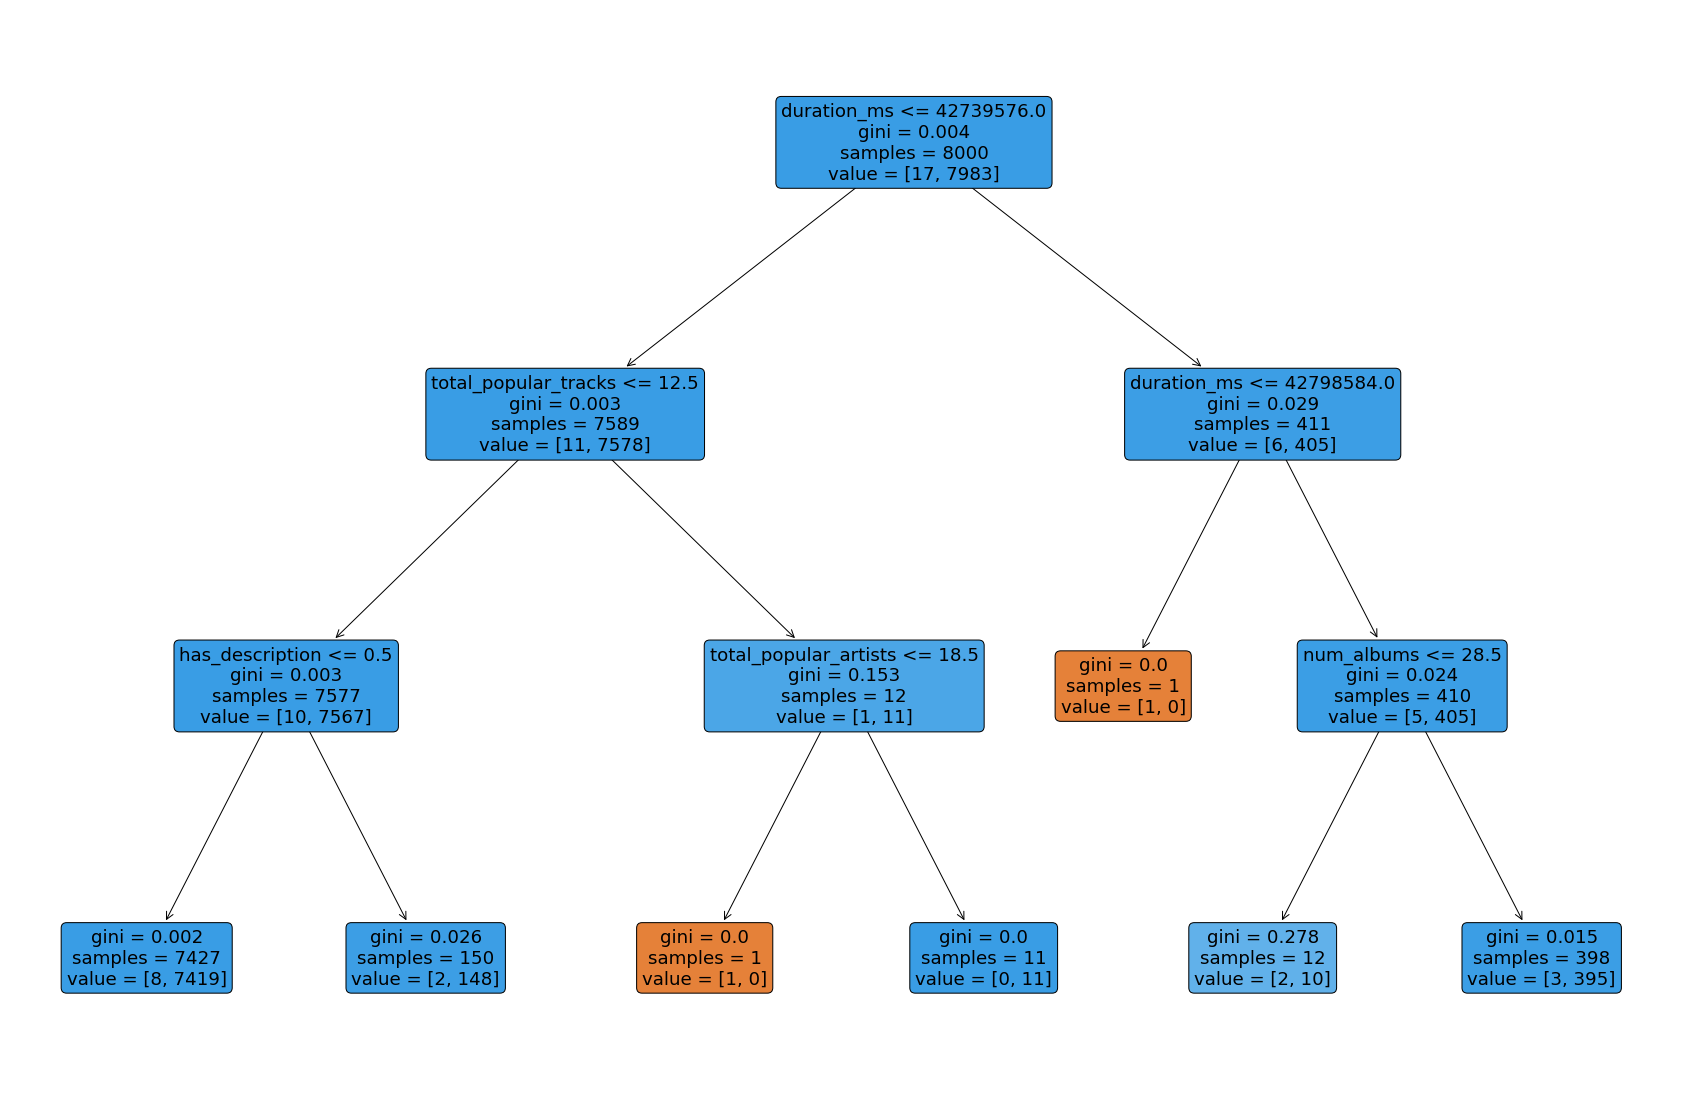

In [30]:
# Initialize a Decision Tree classifier of depth 5 and choose splitting criteria to be gini
baseline_dtree = DecisionTreeClassifier(max_depth = 3, criterion = "gini", random_state = 109)

# Fit the classifier on the train data
print(f"Model Predictors: {list(X_train.columns)}\n")
baseline_dtree.fit(X_train, y_train_cat)
y_train_pred = baseline_dtree.predict(X_train)
print(f"Total Observations: {len(y_train_pred)}\nNumber of observations predicted as popular: {(y_train_pred == 'popular').sum()}\n")

train_accuracy = accuracy_score(y_train_cat, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Plot the Decision Tree trained above with parameters filled as True
plt.figure(figsize = (30, 20))
tree.plot_tree(baseline_dtree, filled = True, rounded = True, feature_names = list(X_train.columns))
plt.show()
